### Introduction

In the previous post, we saw how to do _Image Classification_
by performing crop of the central part of an image and
making an inference using one of the standart classification models.
After that, we saw how to perform the network inference on the whole
image by changing the network to _fully convolutional_ one. This approach
gave us a downsampled prediction map for the image -- that happened due
to the fact that _max-pooling_ layers are used in the network architecture.
This prediction map can be treated as an efficient way to make an inference of
the network for the whole image. You can also think about it as a way to make
_Image Segmentation_, but it is not an actual _Segmentation_, because
the standart network models were trained to perform _Classification_.
To make it perform an actual _Segmentation_, we will have to train it
on _Segmentation_ dataset in a special way like in the paper _Fully convolutional
networks for semantic segmentation_ by Long et al. Two of the most popular general
_Segmentation_ datasets are: [Microsoft COCO](http://mscoco.org/) and [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/).

In this post, we will perform image upsampling to get the prediction map
that is of the same size as an input image. We will do this using _transposed convolution_
(also known as _deconvolution_). It is recommended not to use the _deconvolution_ name for this
operation as it can be confused with another operation and it does not represent accurately
the actual process that is being performed. The most accurate name for the kind of operation
that we will perform in this post is _fractionally strided convolution_. 
We will cover a small part of theory necessary for understanding and some resources will be cited.

One question might be raised up now: Why do we need to perform upsampling using _fractionally
strided convolution_? Why can't we just use some library to do this for us? The answer is: we
need to do this because we need to define the upsampling operation as a layer in the network.
And why do we need it as a layer? Because we will have to perform training where the image and
respective _Segmentation_ groundtruth will be given to us -- and we will have to perform
training using backpropagation.
As it is [known](http://www.robots.ox.ac.uk/~vgg/practicals/cnn/) , each layer in the network has to be able to perform three operations:
_forward propagation_, _backward propagation_ and _update_ which performs updates
to the weights of the layer during training. By doing the upsampling with _transposed convolution_
we will have all of these operations defined and we will be able to perform training.

By the end of the post, we will implement the upsampling and will make sure it is correct
by comparing it to the implementation of the [scikit-image library](http://scikit-image.org/).
To be more specific we will have _FCN-32_ _Segmentation_ network implemented which is
described in the paper _Fully convolutional networks for semantic segmentation_.
To perform the training, the loss function has to be defined and training dataset provided.

### Setup

To be able to run the provided code, follow the previous post and run the
following command to run the code on the first _GPU_ and specify the folder
with downloaded classification models:

In [1]:
from __future__ import division
import sys
import os
import numpy as np
from matplotlib import pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sys.path.append("/home/dpakhom1/workspace/models/slim")

# A place where you have downloaded a network checkpoint -- look at the previous post
checkpoints_dir = '/home/dpakhom1/checkpoints'
sys.path.append("/home/dpakhom1/workspace/models/slim")



### Image Upsampling

_Image Upsampling_ is a specific case of _Resampling_.
According to a definition, provided in [this article about _Resampling_](http://avisynth.nl/index.php/Resampling):


```
The idea behind resampling is to reconstruct the continuous signal from the original sampled signal and resample it again using more samples (which is called interpolation or upsampling) or fewer samples (which is called decimation or downsampling)

```

In other words, we can approximate the continious signal from the points that
we have and sample new ones from the reconstructed signal. So, to be more specific,
in our case, we have downsampled prediction map -- these are points from which we
want to reconstruct original signal. And if we are able to approximate original
signal, we can sample more points and, therefore, perform upsampling.

We say "to approximate" here because the continious signal will most probably
not be reconstructed perfectly. Under a certain ideal conditions, the signal
can be perfectly reconstructed though. There is a _Nyquist–Shannon sampling theorem_
that states that the signal can be ideally reconstructed if _x(t) contains no
sinusoidal component at exactly frequency B, or that B must be strictly less than one half
the sample rate_. Basically, the sampling frequency should be bigger by the factor of two
than the biggest frequency that input signal contains.

But what is the exact equation to get this reconstruction? Taking the equation from this [source](http://avisynth.nl/index.php/Resampling):


s(x) = sum_n s(n*T) * sinc((x-n*T)/T), with sinc(x) = sin(pi*x)/(pi*x) for x!=0, and = 1 for x=0

with fs = 1/T the sampling rate, s(n*T) the samples of s(x) and sinc(x) the resampling kernel.

[Wikipedia article](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) has a great explanation of the equation:

```
A mathematically ideal way to interpolate the sequence involves the use of sinc functions. Each sample in the sequence is replaced by a sinc function, centered on the time axis at the original location of the sample, nT, with the amplitude of the sinc function scaled to the sample value, x[n]. Subsequently, the sinc functions are summed into a continuous function. A mathematically equivalent method is to convolve one sinc function with a series of Dirac delta pulses, weighted by the sample values. Neither method is numerically practical. Instead, some type of approximation of the sinc functions, finite in length, is used. The imperfections attributable to the approximation are known as interpolation error.
```

So, we can see that the continious signal is reconstructed by placing the resampling kernel
function at each point that we have and summing up everything (this explanation omits some 
details for simplicity). It should be stated here that the resampling kernel shouldn't necessary
be sinc function. For example, the bilinear resampling kernel can be useв. You can find more
examples [here](http://avisynth.nl/index.php/Resampling). Also, one important point
from the explanation above is that mathematically equivalent way is to convolve the
kernel function with series of Dirac delta pulses, weighted by the sample values. These
two equavalent ways to perform reconstruction are important as they will make understanding
of how transposed convolution work and that each transposed convolution has an equivalent
convolution.

Let's perform image upsampling using built-in function from [scikit-image library](http://scikit-image.org/).
We will need this to validate if our implementation of bilinear upsampling is correct later in the post.
This is exactly how the implementation of bilinear upsampling [was validated](http://nbviewer.jupyter.org/gist/tnarihi/54744612d35776f53278) before [being merged](https://github.com/BVLC/caffe/pull/2213). Part of the code in the post was taken from
there. Below we will perform the upsampling with _factor_ 3 meaning that an output size
will be three times bigger than an input.



C:\Users\cueva\Anaconda3\envs\nightly\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\cueva\Anaconda3\envs\nightly\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


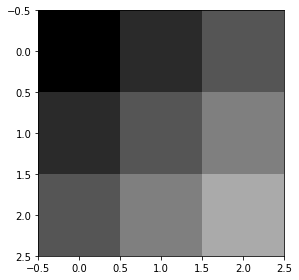

In [2]:
%matplotlib inline

from numpy import ogrid, repeat, newaxis

from skimage import io

# Generate image that will be used for test upsampling
# Number of channels is 3 -- we also treat the number of
# samples like the number of classes, because later on
# that will be used to upsample predictions from the network
imsize = 3
x, y = ogrid[:imsize, :imsize]
img = repeat((x + y)[..., newaxis], 3, 2) / float(imsize + imsize)
io.imshow(img, interpolation='none')

C:\Users\cueva\Anaconda3\envs\nightly\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\cueva\Anaconda3\envs\nightly\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


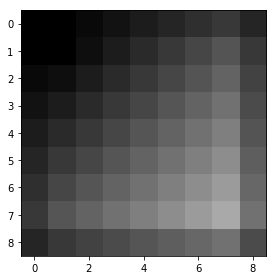

In [3]:
import skimage.transform

def upsample_skimage(factor, input_img):
    
    # Pad with 0 values, similar to how Tensorflow does it.
    # Order=1 is bilinear upsampling
    return skimage.transform.rescale(input_img,
                                     factor,
                                     mode='constant',
                                     cval=0,
                                     order=1)


upsampled_img_skimage = upsample_skimage(factor=3, input_img=img)
io.imshow(upsampled_img_skimage, interpolation='none')

### Transposed convolution

In the paper by Long et al. it was stated that upsampling can be performed using
fractionally strided convolution (transposed convolution). But first it is
necessary to understand how transposed convolution works.To understand that,
we should look at a usual convolution and see that it convolves
the image and depending on the parameters (stride, kernel size, padding) reduces
the input image. What if we would be able to perform an operation that goes
in the opposite direction -- from small input to the bigger one while preserving the
connectivity pattern. Here is an illustration:

![alt text](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_3/Deconv_exp.PNG)

Convolution is a linear operation and, therefore, it can be represented as a matrix
multiplication. To achieve the result described above, we only need to traspose the
matrix that defines a particular convolution. The resulted operation is no longer
a convolution, but it can still be represented as a convolution, which won't be 
as efficient as transposing a convolution. To get more information about the equivalence
and transposed convolution in general we refer reader to [this paper](https://arxiv.org/pdf/1609.07009.pdf)
and [this guide](https://arxiv.org/pdf/1603.07285.pdf).

So, if we define a bilinear upsampling kernel and perform fractionally strided
convolution on the image, we will get an upsampled output, which will be defined
as a layer in the network and will make it possible for us to perform backpropagation.
For the FCN-32 we will use bilinear upsampling kernel as an initialization, meaning that
the network can learn a more suitable kernel during backpropagation.

To make the code below more easy to read, we will provide some statements that can be
derived from the [following article](http://avisynth.nl/index.php/Resampling). The _factor_
of upsampling is equal to the stride of transposed convolution. The kernel of the upsampling
operation is determined by the identity: __2 * factor - factor % 2__.

Below, we will define the bilinear interpolation using transposed convolution operation
in Tensorflow. We will perform this operation on cpu, because later in the post we will
need the same piece of code to perfom memory consuming operation that won't fit into GPU.
After performing the interpolation, we compare our results to the results that were
obtained by the function from scikit-image.

In [4]:
from __future__ import division
import numpy as np
import tensorflow as tf


def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in xrange(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights


def upsample_tf(factor, input_img):
    
    number_of_classes = input_img.shape[2]
    
    new_height = input_img.shape[0] * factor
    new_width = input_img.shape[1] * factor
    
    expanded_img = np.expand_dims(input_img, axis=0)

    with tf.Graph().as_default():
        with tf.Session() as sess:
            with tf.device("/cpu:0"):

                upsample_filt_pl = tf.placeholder(tf.float32)
                logits_pl = tf.placeholder(tf.float32)

                upsample_filter_np = bilinear_upsample_weights(factor, number_of_classes)

                res = tf.nn.conv2d_transpose(logits_pl, upsample_filt_pl,
                                 output_shape=[1, new_height, new_width, number_of_classes],
                                 strides=[1, factor, factor, 1])

                final_result = sess.run(res, feed_dict={upsample_filt_pl: upsample_filter_np,
                                             logits_pl: expanded_img})
    
    return final_result.squeeze()

upsampled_img_tf = upsample_tf(factor=3, input_img=img)
io.imshow(upsampled_img_tf)

NameError: name 'xrange' is not defined

In [ ]:
# Test if the results of upsampling are the same
np.allclose(upsampled_img_skimage, upsampled_img_tf)

In [ ]:
for factor in xrange(2, 10):
    
    upsampled_img_skimage = upsample_skimage(factor=factor, input_img=img)
    upsampled_img_tf = upsample_tf(factor=factor, input_img=img)
    
    are_equal = np.allclose(upsampled_img_skimage, upsampled_img_tf)
    
    print("Check for factor {}: {}".format(factor, are_equal))

### Upsampled predictions

So let's apply our upsampling to the actual predictions. We will take the _VGG-16_
model that we used in the previous post for classification and apply our upsampling
to the downsampled predictions that we get from the network.

Before applying the code below I had to change a [certain line](https://github.com/tensorflow/tensorflow/blob/r0.11/tensorflow/contrib/slim/python/slim/nets/vgg.py#L165)
in the definition of _VGG-16_ model to prevent it from reducing the size even more. To be more specific,
I had to change the _7x7_ convolutional layer padding to _SAME_ option. This was done by the authors
because they wanted to get single prediction for the input image of standart size. But in case of segmentation
we don't need this, because otherwise by upsampling by factor 32 we won't get
the image of the same size as the input. After making the aforementioned change, the issue was eliminated.

Be careful because the code below and specifically the upsampling variable consumes a huge
amount of space (~15 Gb). This is due to the fact that we have huge filters _64 by 64_
and _1000_ classes. Moreover, we actually don't use a lot of space of the upsampling variable,
because we define only the diagonal submatrices, therefore, a lot of space is wasted.
This is only done for demonstration purposes for _1000_ classes and standart _Segmentation_
datasets usually contain less classes (20 classes on PASCAL VOC).

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt

import numpy as np
import os
import tensorflow as tf
import urllib2

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

checkpoints_dir = '/home/dpakhom1/checkpoints'

slim = tf.contrib.slim

# Load the mean pixel values and the function
# that performs the subtraction
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)

slim = tf.contrib.slim
# Function to nicely print segmentation results with
# colorbar showing class names
def discrete_matshow(data, labels_names=[], title=""):
    
    fig_size = [7, 6]
    plt.rcParams["figure.figsize"] = fig_size
    
    #get discrete colormap
    cmap = plt.get_cmap('Paired', np.max(data)-np.min(data)+1)
    
    # set limits .5 outside true range
    mat = plt.matshow(data,
                      cmap=cmap,
                      vmin = np.min(data)-.5,
                      vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat,
                       ticks=np.arange(np.min(data),np.max(data)+1))
    
    # The names to be printed aside the colorbar
    if labels_names:
        cax.ax.set_yticklabels(labels_names)
    
    if title:
        plt.suptitle(title, fontsize=15, fontweight='bold')


with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/"
           "First_Student_IC_school_bus_202076.jpg")
    
    image_string = urllib2.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Convert image to float32 before subtracting the
    # mean pixel value
    image_float = tf.to_float(image, name='ToFloat')
    
    # Subtract the mean pixel value from each pixel
    processed_image = _mean_image_subtraction(image_float,
                                              [_R_MEAN, _G_MEAN, _B_MEAN])

    input_image = tf.expand_dims(processed_image, 0)
    
    with slim.arg_scope(vgg.vgg_arg_scope()):
        
        # spatial_squeeze option enables to use network in a fully
        # convolutional manner
        logits, _ = vgg.vgg_16(input_image,
                               num_classes=1000,
                               is_training=False,
                               spatial_squeeze=False)
    
    # For each pixel we get predictions for each class
    # out of 1000. We need to pick the one with the highest
    # probability. To be more precise, these are not probabilities,
    # because we didn't apply softmax. But if we pick a class
    # with the highest value it will be equivalent to picking
    # the highest value after applying softmax
    pred = tf.argmax(logits, dimension=3)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        init_fn(sess)
        segmentation, np_image, np_logits = sess.run([pred, image, logits])

# Remove the first empty dimension
segmentation = np.squeeze(segmentation)

names = imagenet.create_readable_names_for_imagenet_labels()

# Let's get unique predicted classes (from 0 to 1000) and
# relable the original predictions so that classes are
# numerated starting from zero
unique_classes, relabeled_image = np.unique(segmentation,
                                            return_inverse=True)

segmentation_size = segmentation.shape

relabeled_image = relabeled_image.reshape(segmentation_size)

labels_names = []

for index, current_class_number in enumerate(unique_classes):

    labels_names.append(str(index) + ' ' + names[current_class_number+1])

# Show the downloaded image
plt.figure()
plt.imshow(np_image.astype(np.uint8))
plt.suptitle("Input Image", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

discrete_matshow(data=relabeled_image, labels_names=labels_names, title="Segmentation")



And now let's upsample the predictions that we got for the image using the bilinear
upsampling kernel.

In [ ]:
upsampled_logits = upsample_tf(factor=32, input_img=np_logits.squeeze())
upsampled_predictions = upsampled_logits.squeeze().argmax(axis=2)

unique_classes, relabeled_image = np.unique(upsampled_predictions,
                                            return_inverse=True)

relabeled_image = relabeled_image.reshape(upsampled_predictions.shape)

labels_names = []

for index, current_class_number in enumerate(unique_classes):

    labels_names.append(str(index) + ' ' + names[current_class_number+1])

# Show the downloaded image
plt.figure()
plt.imshow(np_image.astype(np.uint8))
plt.suptitle("Input Image", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

discrete_matshow(data=relabeled_image, labels_names=labels_names, title="Segmentation")

The ouput results that we got are quite noisy, but we got an approximate segmentation for the bus.
To be more precise, it is not a segmentation but regions where the network was evaluated
and gave the following predictions.

The next stage is to perform training of the whole system on a specific Segmentation dataset.

### Conclusion and Discussion

In this post we covered the transposed convolution and specifically the
implementation of bilinear interpolation using transposed convolution. We applied
it to downsampled predictions to upsample them and get predictions for the whole
input image.

We also saw that you might experience problems with space if you do segmentation
for a huge number of classes. Because of that, we had to perform that operation
on CPU and load weights of upsampling filter into RAM instead of GPU.